# Reproducing Figure 12

In [2]:
###################
# Import packages #
###################

import sys
import numpy as np
sys.path.append('../code/')
from gwBackground import *
from jax.scipy.special import gammainc
from util import precompute_omega_weights, unpack_rate_file

In [3]:
##############################
# Things related to plotting #
##############################

import matplotlib.pylab as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"]="Times New Roman"
rc_fonts = {
"text.usetex": True,
}
plt.rcParams.update(rc_fonts)
plt.rcParams["figure.figsize"] = (8,6) 

import seaborn as sns
my_palette = sns.color_palette("colorblind")

## Define population

In [4]:
mMin = 5
mMax = 85
alpha = -3.5
mu_m1 = 20
sig_m1 = 3
log_f_peak = -2
bq = 0.8
R20 = 0.1
log_dmMax = 1
log_dmMin = -0.5
tmp_min = 2
tmp_max = 100

freqs = np.linspace(10,1000,1000)

## Compute $\Omega(f)$ performing the integral over a grid

In [5]:
all_zs = np.linspace(0,10,200) 
omg = OmegaGW_BBH(2.01,100.,all_zs, gridSize=(140,130))

In [6]:
omg.setProbs_plPeak(mMin,mMax,alpha,mu_m1,sig_m1,10.**log_f_peak,bq, R20, 10.**log_dmMax,10.**log_dmMin)

In [7]:
rate_file_path = "../input/delayedRateDataMD.npy"
formationRates, tdelays, zformation, zs = unpack_rate_file(rate_file_path)

We then define the merger rate for a set of benchmark values:

In [8]:
td_min_bench = 0.05
Z_max_bench = .01
lambda_td = -1

fs = gammainc(0.84,(Z_max_bench**2.)*np.power(10.,0.3*zformation))
weightedFormationRates = formationRates*fs

dpdt = jnp.power(tdelays,lambda_td)
dpdt = jnp.where(tdelays>0.05,dpdt,0)

dpdt = jnp.where(tdelays<13.5,dpdt,0)
mergerRate = weightedFormationRates.dot(dpdt)

rate = np.interp(all_zs, zs, mergerRate)
rate_02 = np.interp(0.2, zs, mergerRate)

Computing the spectrum using a grid-based approach gives:

In [9]:
Omega_f = omg.eval(rate, rate_02, freqs)

(1e-11, 1e-09)

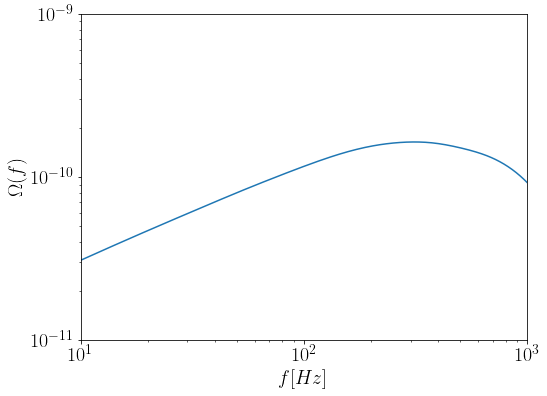

In [10]:
plt.loglog(freqs, Omega_f, rasterized=True)
plt.xlabel('$f [Hz]$')
plt.ylabel('$\Omega(f)$')
plt.xlim(10,1000)
plt.ylim(1e-11,1e-9)

## Approximating the spectrum using a Monte Carlo integral

To illustrate the convergence of the approach, we will consider different numbers of draws: N_array = 1000, 5000, and 20000 (the latter being the one used in our analysis)

In [11]:
N = np.array([1000,5000,20000])
omega_array = np.zeros(3, dtype=np.ndarray)

In [12]:
def f_z(z):
    rate = jnp.interp(z, zs, mergerRate)
    rate_final = rate/jnp.sqrt(OmgM*(1.+z)**3.+OmgL)/(1.+z)
    return rate_final

p_z_norm = rate = jnp.interp(0.2, zs, mergerRate)
p_m1_norm = massModel(20,alpha, mu_m1,sig_m1,10.**log_f_peak, mMax, mMin, 10.**log_dmMax,10.**log_dmMin)

In [13]:
for ii in range(3):
    m1s_drawn, m2s_drawn, zs_drawn, p_m1_old, p_m2_old, p_z_old, dEdfs = precompute_omega_weights(freqs, N=N[ii], tmp_min = tmp_min, tmp_max=tmp_max)
    
    p_m2_new = ((1.+bq)*jnp.power(m2s_drawn,bq)/(jnp.power(m1s_drawn,1.+bq)-tmp_min**(1.+bq)))
    p_m1_new = massModel(m1s_drawn,alpha, mu_m1,sig_m1,10.**log_f_peak, mMax, mMin, 10.**log_dmMax,10.**log_dmMin)
    p_z_new = f_z(zs_drawn)
        
    w_i = p_z_new*p_m1_new*p_m2_new/(p_z_old*p_m1_old*p_m2_old)
        
    Omega_spectrum_new = (freqs)*(jnp.einsum("if,i->if",dEdfs,w_i))
    Omega_spectrum_new_avged = 1/rhoC/H0*R20/1e9/year/p_z_norm/p_m1_norm*jnp.mean(Omega_spectrum_new, axis=0)
    omega_array[ii] = Omega_spectrum_new_avged

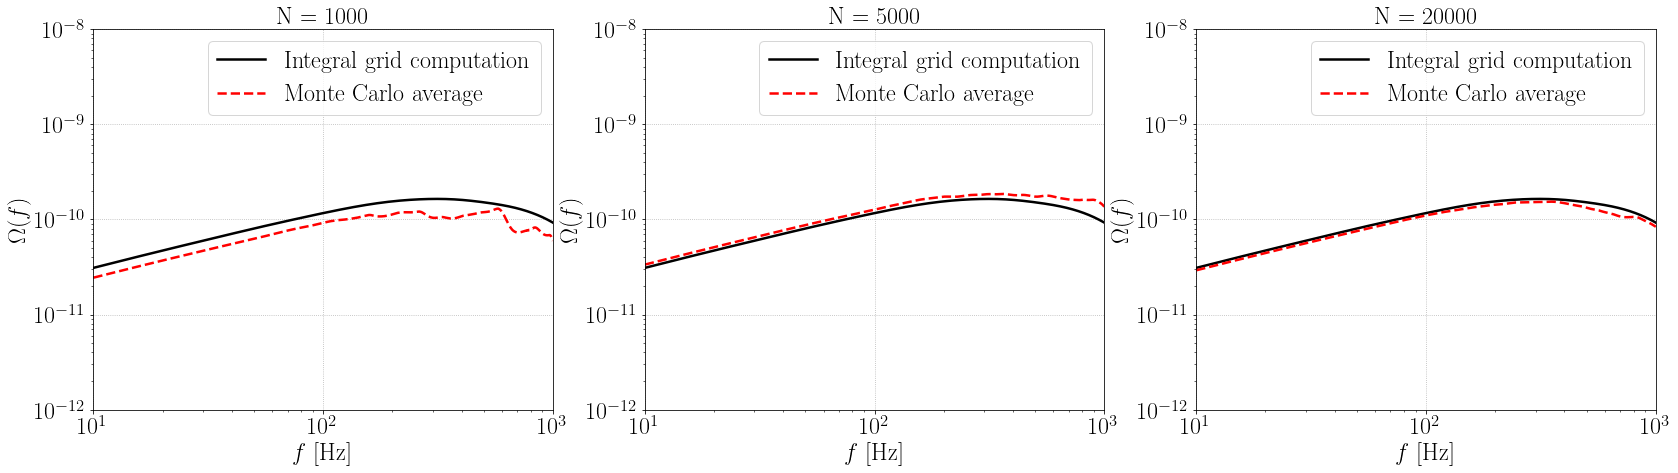

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(28, 7))
for ii in range(3):
    axs[ii].loglog(freqs, Omega_f,c='k',lw=2.5, rasterized=True, label="Integral grid computation")
    axs[ii].loglog(freqs, omega_array[ii],lw=2.5, rasterized=True, c='r',ls='dashed', label="Monte Carlo average")
    axs[ii].set_xlabel("$f$ [Hz]",fontsize=24)
    axs[ii].set_ylabel("$\\Omega(f)$", fontsize=24)
    axs[ii].set_title("N = "+str(N[ii]))
    axs[ii].set_xlim(freqs[0],freqs[-1])
    axs[ii].set_ylim(1e-12,1e-8)
    axs[ii].tick_params(axis='both', which='major', labelsize=24)
    axs[ii].legend(fontsize=24)
    axs[ii].grid(visible=True, ls='dotted')
plt.savefig("MCcomparison.pdf",dpi=500,bbox_inches='tight')